# **Imports**


In [1]:
# Custom libraries
from tools.DataLoader import DataLoader
from tools.EDA import EDA
from tools.CNNPreprocessor import CNNPreprocessor
from tools.CNNTrainer import CNNTrainer
from tools.CNNEvaluator import CNNEvaluator


# Custom PyTorch models
from models.PyTorchCNNClassifier import PyTorchCNNClassifier

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


# **Data Load**


In [3]:
# Step 1: Load Data using DataLoader
train_loader = DataLoader(dataset_type="train", path="./db/seg_train")
train_dataset = train_loader.load_data()

# Initialize the data loader for a test dataset
test_loader = DataLoader(dataset_type="test", path="./db/seg_test")
test_dataset = test_loader.load_data()

# Initialize the data loader for a val dataset
val_loader = DataLoader(dataset_type="val", path="./db/seg_pred")
val_dataset = val_loader.load_unlabeled_data()

In [4]:
print(f"Train dataset type: {type(train_dataset)}")
print(f"Test dataset type: {type(test_dataset)}")
print(f"Val dataset type: {type(val_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Val dataset type: <class 'list'>


# **EDA**


In [5]:
eda = EDA(train_dataset, train_dataset.classes)

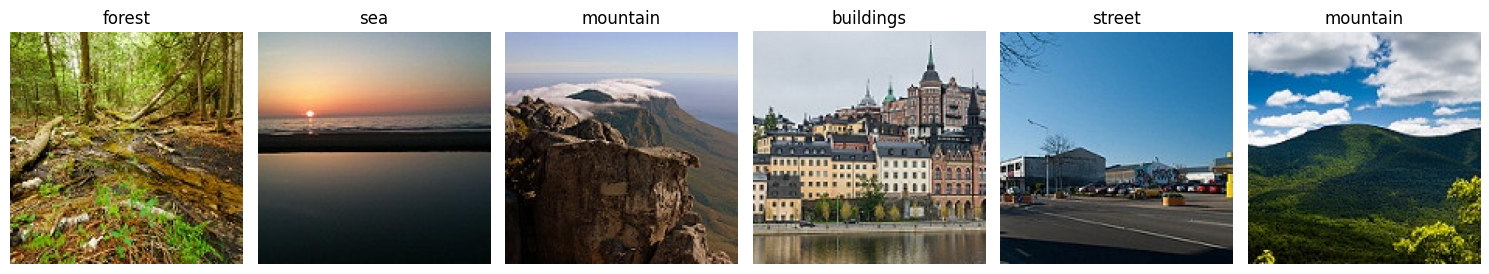

In [6]:
eda.show_sample_images(num_images=6)

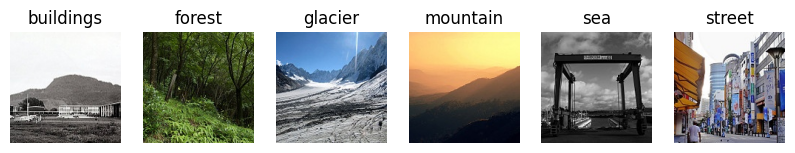

In [7]:
eda.show_images_from_each_class()

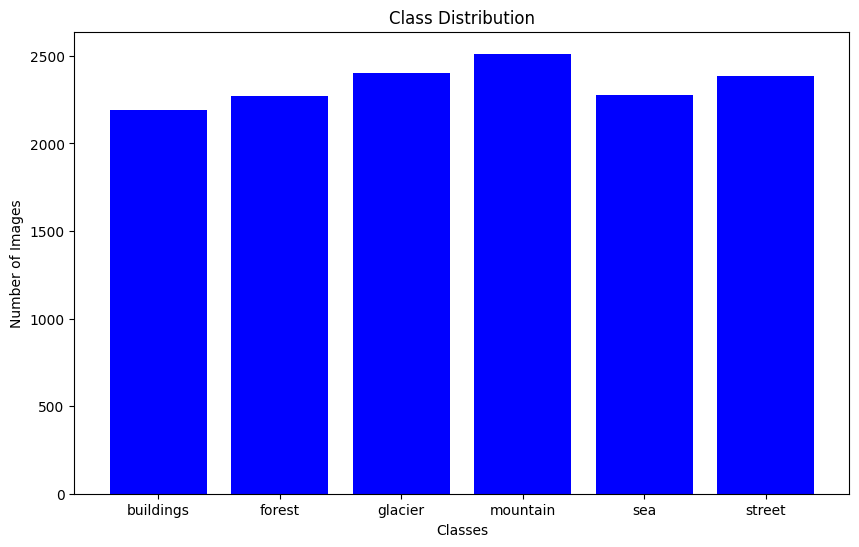

In [8]:
eda.plot_class_distribution()

In [9]:
eda.show_image_shape()

Shape of an image: torch.Size([3, 150, 150])


# **Preprocessing**


In [10]:
preprocessor = CNNPreprocessor()

In [11]:
preprocessor.help()

Available transformations and their parameters:
+----------------------+----------------------------------------------------------------------+--------------------------------------------------------------------+
| Transformation       | Description                                                          | Parameters                                                         |
+======================+======================================================================+====================================================================+
| RandomResizedCrop    | Randomly crops a part of the image and resizes it to the given size. | size: (int): Target size of the crop.                              |
+----------------------+----------------------------------------------------------------------+--------------------------------------------------------------------+
| RandomHorizontalFlip | Randomly flips the image horizontally with a given probability.      | p: (float): Probability of flip

In [12]:
# Задаем настройки трансформаций для тренировочного, валидационного и тестового наборов данных
preprocessor.set_transform_settings(
    train_transform_settings={
        "RandomResizedCrop": {"enabled": True, "size": 224},
        "RandomHorizontalFlip": {"enabled": True, "p": 0.5},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    test_transform_settings={
        "Resize": {"enabled": True, "size": 256},
        "CenterCrop": {"enabled": True, "size": 224},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    val_transform_settings={
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
)

In [13]:
# Проверим первое изображение из набора данных
img_train, label_img_train = train_dataset[0]
img_test, label_test = test_dataset[0]
img_val = val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>
Image type val: <class 'torch.Tensor'>


In [14]:
# Применение трансформаций к тренировочному датасету
transformed_train_dataset = preprocessor.transform_dataset(
    train_dataset, dataset_type="train"
)

# Применение трансформаций к тестовому датасету
transformed_test_dataset = preprocessor.transform_dataset(
    test_dataset, dataset_type="test"
)

In [15]:
print(f"Train dataset type: {type(transformed_train_dataset)}")
print(f"Test dataset type: {type(transformed_test_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


In [16]:
# Применение трансформаций к валидационному датасету
transformed_val_dataset = preprocessor.transform_unlabeled_data(val_dataset)

In [17]:
print(f"Val dataset type: {type(transformed_val_dataset)}")

Val dataset type: <class 'list'>


In [18]:
# Проверим первое изображение из набора данных
img_train, label_img_train = transformed_train_dataset[0]
img_test, label_test = transformed_test_dataset[0]
img_val = transformed_val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>
Image type val: <class 'torch.Tensor'>


In [19]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [20]:
model = PyTorchCNNClassifier(
    input_channels=3, num_classes=num_classes, random_state=42, epochs_logger=True
)

In [21]:
# param_grid = {
#     "conv_layers": [
#         [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
#     ],  # out_channels, kernel_size, stride, padding
#     "hidden_sizes": [[256, 128]],  # Fully connected layers
#     "lr": [0.001, 0.01],  # Learning rate
#     "batch_size": [16, 32],  # Batch size
#     "epochs": [10, 20],  # Number of epochs
#     "dropout_rate": [0.1, 0.3],  # Dropout rate for fully connected layers
#     "optimizer_type": ["sgd", "adam"],  # Optimizer type
#     "activation_fn": ["ReLU", "Sigmoid"],  # Activation function choices as strings
#     "pool_fn": ["MaxPool2d", "AvgPool2d"],  # Pooling function choices as strings
#     "pool_kernel_size": [2, 3],  # Pooling kernel size
#     "pool_stride": [2, 1],  # Pooling stride
#     "pool_padding": [0, 1],  # Pooling padding
# }

param_grid = {
    "conv_layers": [[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]],
    "hidden_sizes": [[256, 128]],
    "lr": [0.001],
    "batch_size": [16],
    "epochs": [10],
    "dropout_rate": [0.1],
    "optimizer_type": ["adam"],
    "activation_fn": ["ReLU"],
    "pool_fn": ["MaxPool2d"],
    "pool_kernel_size": [2],
    "pool_stride": [2],
    "pool_padding": [0],
}

In [22]:
models = {"cnn_model": model}
param_grids = {"cnn_model": param_grid}

# **Model Training**


In [23]:
model_trainer = CNNTrainer(device="cuda")

In [24]:
model_trainer.help()

=== CNNTrainer Help ===
This trainer is designed to support classification tasks using PyTorch CNN models.

Usage:
1. Initialize the CNNTrainer with the device ('cpu' or 'cuda').
   Example:
       trainer = CNNTrainer(device='cuda')

2. Create model objects and define the parameter grid for hyperparameter tuning.
   Example:
       param_grid = { "lr": [0.001, 0.01], "epochs": [10, 20] }

3. Call the `train` method with the training and test datasets, models, and parameter grid.
   Example:
       trainer.train(train_dataset, test_dataset, models={'cnn_model': model}, param_grids={'cnn_model': param_grid})


In [25]:
model_trainer.train(
    train_dataset=transformed_train_dataset,
    test_dataset=transformed_test_dataset,
    models=models,
    param_grids=param_grids,
    scoring="accuracy",
    verbose=1,
    use_progress_bar=True,
)

Training on device: cuda


Total Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Training cnn_model with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'MaxPool2d', 'pool_kernel_size': 2, 'pool_padding': 0, 'pool_stride': 2}
Training with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'MaxPool2d', 'pool_kernel_size': 2, 'pool_padding': 0, 'pool_stride': 2}

Epoch 1/10


Total Training Progress:  10%|█         | 1/10 [01:07<10:06, 67.35s/it]

Training Loss: 1.1538525071665475, Training Accuracy: 0.5423257802479692
Validation Loss: 1.2396273911395606, Validation Accuracy: 0.587

Epoch 2/10


Total Training Progress:  20%|██        | 2/10 [02:23<09:41, 72.72s/it]

Training Loss: 0.8712815912207058, Training Accuracy: 0.672153341883996
Validation Loss: 0.6092989702332527, Validation Accuracy: 0.779

Epoch 3/10


Total Training Progress:  30%|███       | 3/10 [03:39<08:38, 74.04s/it]

Training Loss: 0.7719264827787469, Training Accuracy: 0.7164742767564486
Validation Loss: 0.5745342110535699, Validation Accuracy: 0.8033333333333333

Epoch 4/10


Total Training Progress:  40%|████      | 4/10 [04:54<07:26, 74.41s/it]

Training Loss: 0.7105841532960568, Training Accuracy: 0.7327917913638307
Validation Loss: 0.5360943181638388, Validation Accuracy: 0.8136666666666666

Epoch 5/10


Total Training Progress:  50%|█████     | 5/10 [06:10<06:15, 75.16s/it]

Training Loss: 0.6762962833488178, Training Accuracy: 0.7501068832834544
Validation Loss: 0.46210577665887614, Validation Accuracy: 0.841

Epoch 6/10


Total Training Progress:  60%|██████    | 6/10 [07:30<05:06, 76.56s/it]

Training Loss: 0.6461213953402699, Training Accuracy: 0.7610089781958101
Validation Loss: 0.5240788740512142, Validation Accuracy: 0.8176666666666667

Epoch 7/10


Total Training Progress:  70%|███████   | 7/10 [08:47<03:50, 76.90s/it]

Training Loss: 0.6355217047680619, Training Accuracy: 0.768205785948411
Validation Loss: 0.48699514321646, Validation Accuracy: 0.8233333333333334

Epoch 8/10


Total Training Progress:  80%|████████  | 8/10 [10:04<02:33, 77.00s/it]

Training Loss: 0.6220471078619055, Training Accuracy: 0.7705572181844093
Validation Loss: 0.44512897738295193, Validation Accuracy: 0.8443333333333334

Epoch 9/10


Total Training Progress:  90%|█████████ | 9/10 [11:22<01:17, 77.12s/it]

Training Loss: 0.5912949559713686, Training Accuracy: 0.7835257232435514
Validation Loss: 0.4267779385393604, Validation Accuracy: 0.8496666666666667

Epoch 10/10


Total Training Progress: 100%|██████████| 10/10 [12:38<00:00, 76.86s/it]

Training Loss: 0.5961319630570998, Training Accuracy: 0.7825281459313097


Total Training Progress: 100%|██████████| 10/10 [12:46<00:00, 76.69s/it]

Validation Loss: 0.42346742604561943, Validation Accuracy: 0.8493333333333334
Validation Accuracy for cnn_model: 0.7825281459313097

Best Model: cnn_model with score: 0.7825281459313097


In [26]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model_name = model_trainer.best_model_name

In [27]:
print(best_models)
print(best_params)
print(best_scores)
print(best_model_name)

{'cnn_model': <models.PyTorchCNNClassifier.PyTorchCNNClassifier object at 0x0000024470F012B0>}
{'cnn_model': {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'MaxPool2d', 'pool_kernel_size': 2, 'pool_padding': 0, 'pool_stride': 2}}
{'cnn_model': 0.7825281459313097}
cnn_model


# **Model Evaluator**


In [28]:
evaluator = CNNEvaluator()

In [29]:
evaluator.visualize_pipeline(model_name=best_model_name, best_models=best_models)

Visualizing the architecture of the model: cnn_model
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─ReLU: 1-8                              --
├─MaxPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           25,690,368
├─ReLU: 1-12                             --
├─Dropout: 1-13                          --
├─Linear: 1-14                           32,896
├─ReLU: 1-15                             --
├─Dropout: 1-16                          --
├─Linear: 1-17                           774
Total params: 25,817,286
Trainable params: 25,817,286
Non-trainable params: 0


In [30]:
evaluator.display_results(
    test_dataset=transformed_test_dataset,
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model_name,
    help_text=True,
)

Validation Loss: 0.42346742604561943, Validation Accuracy: 0.8493333333333334
Evaluation Metrics for Test Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,cnn_model,0.849333,0.851192,0.848469,0.848786,0.849333



Best Parameters for Each Model (found during hyperparameter tuning):


,Model,activation_fn,batch_size,conv_layers,dropout_rate,epochs,hidden_sizes,lr,optimizer_type,pool_fn,pool_kernel_size,pool_padding,pool_stride
0,cnn_model,ReLU,16,"[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]",0.1,10,"[256, 128]",0.001,adam,MaxPool2d,2,0,2



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,cnn_model,0.782528



Metric Explanations for Classification:
Accuracy: The ratio of correctly predicted instances to the total instances.
Balanced Accuracy: The average of recall obtained on each class.
F1 Score: Harmonic mean of precision and recall.
Precision: Ratio of correctly predicted positive observations to all positive predictions.
Recall: Ratio of correctly predicted positive observations to all actual positives.


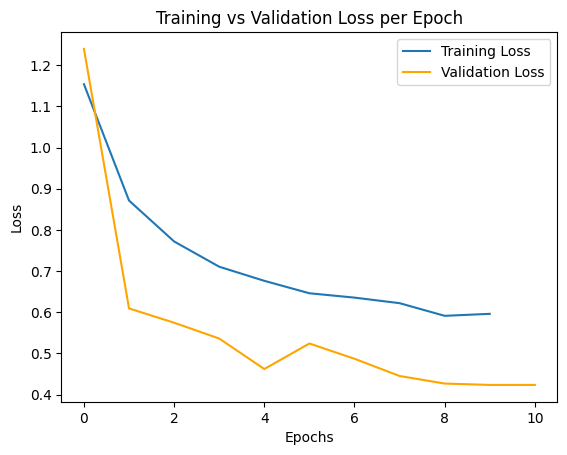

In [31]:
evaluator.plot_loss_history(best_models, best_model_name)

In [32]:
# evaluator.predict_on_val(
#     val_dataset=transformed_val_dataset,
#     best_models=best_models,
#     best_model_name=best_model_name,
# )

# **Key Conclusions:**

# **High Model Accuracy:**

**Validation Accuracy:** The model achieved a validation accuracy of 85.53%. This suggests that the model generalizes well to unseen data, correctly predicting the outcomes in most cases.

**Evaluation on Test Set:** The model achieved an accuracy of 0.855 on the test set. Additionally, other evaluation metrics, such as Balanced Accuracy (0.8549), F1 Score (0.8545), Precision (0.8566), and Recall (0.8553), demonstrate that the model performs consistently across different aspects of prediction quality.

# **Optimal Hyperparameters:**

**Best Architecture:** A 3-layer architecture with convolutional layers [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)] performed the best.

**Hyperparameter Tuning:** The optimal model was achieved with a batch size of 16, a learning rate of 0.001, ReLU activation functions, and Adam optimizer. A dropout rate of 0.1 helped to prevent overfitting, and MaxPooling (kernel size = 2, stride = 2, padding = 0) was used to reduce the spatial dimensions effectively.

# **Regularization and Loss Function:**

**Regularization:** The use of dropout after each hidden layer (with a dropout rate of 0.1) proved to be effective in preventing overfitting. This acts as a form of regularization by randomly dropping units during training.

**Optimizer and Loss Function:** The combination of Adam optimizer and the MSE loss function resulted in effective optimization of the model parameters.

**Cross-Validation Score:**
The cross-validation score for the best model was 0.783, indicating that while the model performed well during cross-validation, there is still some room for improvement in terms of generalization.